## 打包了一个绘制candlestick图的简单接口

主要功能：
- 在图中打买卖标记，标记的时间戳和candle bar时间戳不一致时能找到正确的bar
- 方便批量输出很多图
- 支持多种调整，例如添加隔夜的间距等

In [2]:
import os
import pandas as pd
import numpy as np
import datetime
from candle_plot import candle_plot

%matplotlib inline
pd.set_option('display.min_rows', 20)

### Load sample data

In [3]:
import pickle

with open('sample_trades_2s.pkl', 'rb') as fin:
    sample_trades_2s = pickle.load(fin)

In [4]:
# Wrap up data in X min interval

def create_bar_data(symbol, date, last_n_days, new_interval='5T'):
    trades = sample_trades_2s[symbol].loc[date][['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    trades.index = pd.to_datetime(f'{date} ' + trades.index)
    bars = trades.resample(new_interval).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

    if last_n_days > 0:
        symbol_dates = sample_trades_2s[symbol].index.unique(0)
        i = symbol_dates.get_loc(date)
        last_dates = symbol_dates[i-last_n_days:i]
        for _date in last_dates:
            _trades = sample_trades_2s[symbol].loc[_date][['Open', 'High', 'Low', 'Close', 'Volume']].copy()
            _trades.index = pd.to_datetime(f'{_date} ' + _trades.index)
            _trades = _trades.resample(new_interval).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
            bars = pd.concat([bars, _trades])
    bars.sort_index(inplace=True)
    return bars

### Plot 5min candlesticks on 20201225 with previous 5 days

,Open,High,Low,Close,Volume
Time,,,,,
2020-12-18 09:30:00,12.29,12.43,12.21,12.23,7211101
2020-12-18 09:35:00,12.23,12.37,12.22,12.29,3555763
2020-12-18 09:40:00,12.30,12.46,12.28,12.36,3891897
2020-12-18 09:45:00,12.36,12.38,12.30,12.38,3798102
2020-12-18 09:50:00,12.38,12.42,12.32,12.32,3686577
2020-12-18 09:55:00,12.33,12.33,12.22,12.24,3254198
2020-12-18 10:00:00,12.25,12.31,12.24,12.28,1918700
2020-12-18 10:05:00,12.27,12.37,12.25,12.37,3311700
2020-12-18 10:10:00,12.34,12.40,12.29,12.30,2713300


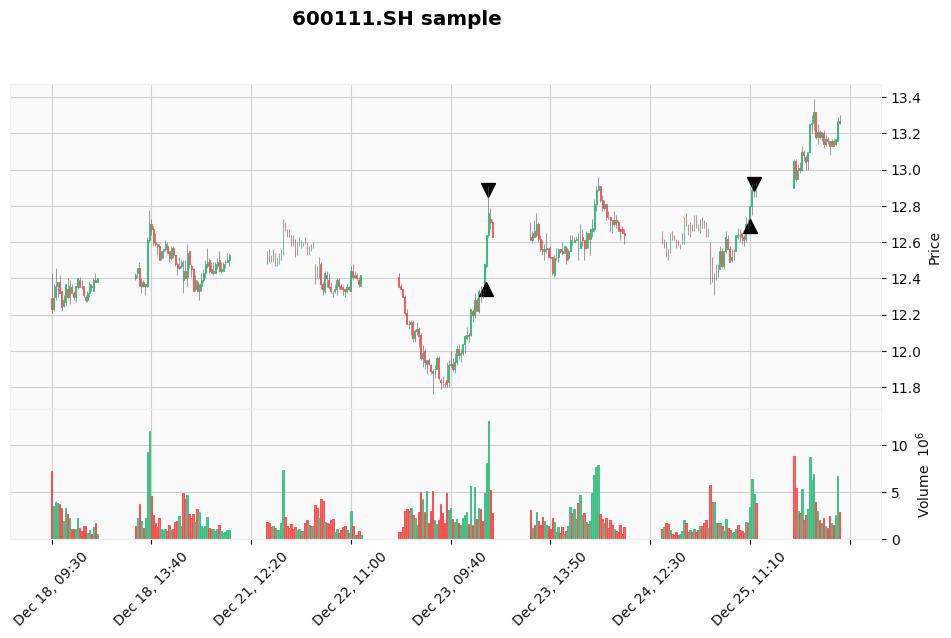

In [5]:
symbol = '600111.SH'
date = '20201225'
new_interval = '5T'
last_n_days = 5

bars = create_bar_data(symbol, date, last_n_days, new_interval)
display(bars)

# Create sample marks
buy_marks = pd.Series(data=[12.69, 12.34], index=pd.to_datetime(['2020-12-25 11:10:00', '2020-12-23 11:10:00']))
buy_marks = {'black': buy_marks}
sell_marks = pd.Series(data=[12.92, 12.89], index=pd.to_datetime(['2020-12-25 11:20:00', '2020-12-23 11:15:00']))
sell_marks = {'black': sell_marks}

candle_plot(bars, f'{symbol} sample', buy_marks, sell_marks, mark_size=100, show_marks=True)

### Remove disturbing noon break and add day gap

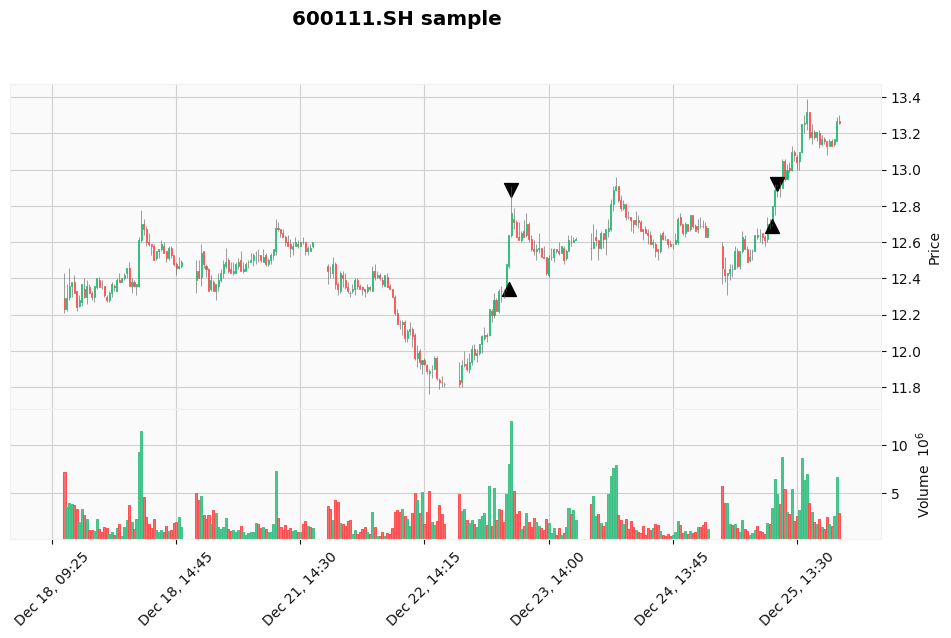

In [5]:
candle_plot(bars, f'{symbol} sample', buy_marks, sell_marks, mark_size=100, show_marks=True, del_nan=True, day_gap=True)

### Zoom in to the last two days
- no need to make changes to the marks---those outside are not shown

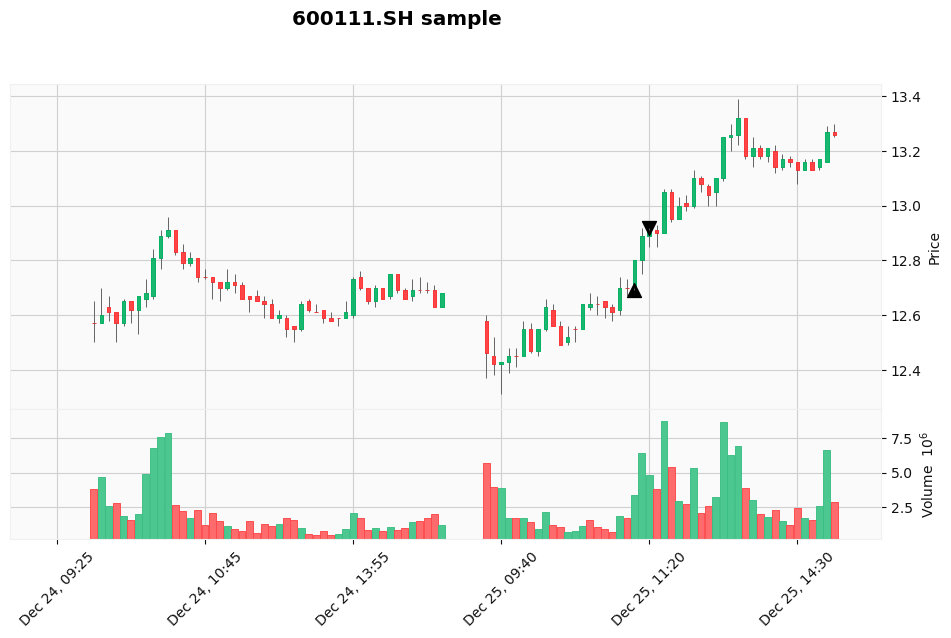

In [6]:
symbol = '600111.SH'
date = '20201225'
new_interval = '5T'
last_n_days = 1

# Make two-day bars
bars = create_bar_data(symbol, date, last_n_days, new_interval)

# No need to make changes to buy/sell marks
candle_plot(bars, f'{symbol} sample', buy_marks, sell_marks, mark_size=100, show_marks=True, del_nan=True, day_gap=True)

### The marks' timestamps do not need to match timestamps of bars
- They will be aligned to the correct bars if not matched

,Open,High,Low,Close,Volume
Time,,,,,
2020-12-24 09:30:00,12.57,12.65,12.50,12.57,3811328
2020-12-24 09:35:00,12.57,12.70,12.57,12.60,4703200
2020-12-24 09:40:00,12.63,12.67,12.58,12.61,2557190
2020-12-24 09:45:00,12.61,12.61,12.50,12.57,2743010
2020-12-24 09:50:00,12.57,12.66,12.56,12.65,1812515
2020-12-24 09:55:00,12.65,12.65,12.57,12.62,1555600
2020-12-24 10:00:00,12.62,12.67,12.53,12.67,1943691
2020-12-24 10:05:00,12.66,12.73,12.63,12.68,4871556
2020-12-24 10:10:00,12.67,12.84,12.66,12.81,6796499


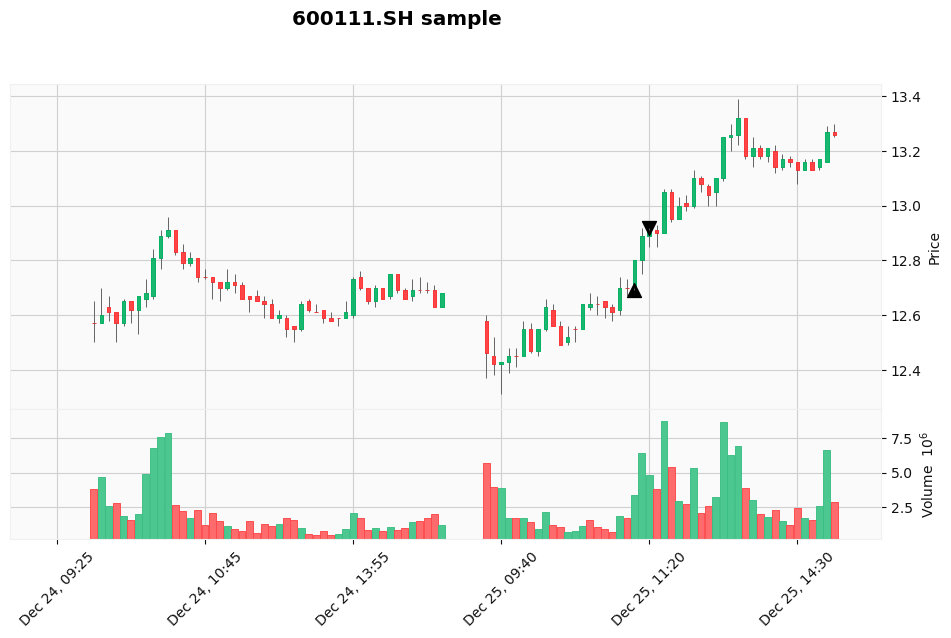

In [7]:
display(bars)

# Marks having timestamps not found in bars
buy_marks = pd.Series(data=[12.69, 12.34], index=pd.to_datetime(['2020-12-25 11:11:10', '2020-12-23 11:12:00']))
buy_marks = {'black': buy_marks}
sell_marks = pd.Series(data=[12.92, 12.89], index=pd.to_datetime(['2020-12-25 11:23:02', '2020-12-23 11:19:54']))
sell_marks = {'black': sell_marks}

candle_plot(bars, f'{symbol} sample', buy_marks, sell_marks, mark_size=100, show_marks=True, del_nan=True, day_gap=True)

### Add another group of marks, and change their sizes

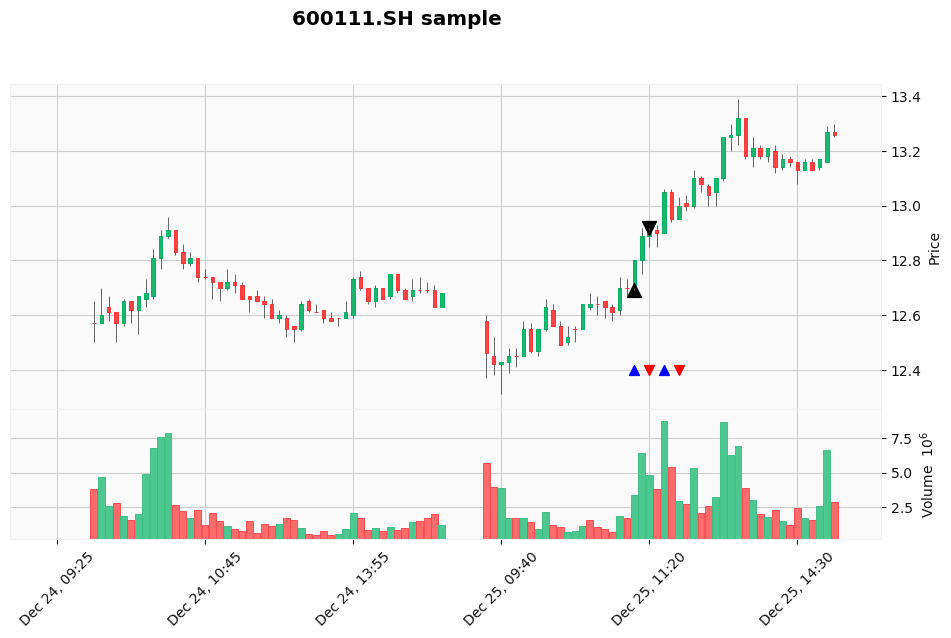

In [8]:
buy_marks['blue-50'] = pd.Series(data=[12.4, 12.4], index=pd.to_datetime(['2020-12-25 11:10:00', '2020-12-25 13:00:00']))
sell_marks['red-50'] = pd.Series(data=[12.4, 12.4], index=pd.to_datetime(['2020-12-25 11:20:00', '2020-12-25 13:10:00']))

candle_plot(bars, f'{symbol} sample', buy_marks, sell_marks, mark_size=100, show_marks=True, del_nan=True, day_gap=True)

### Sometimes, line style is better

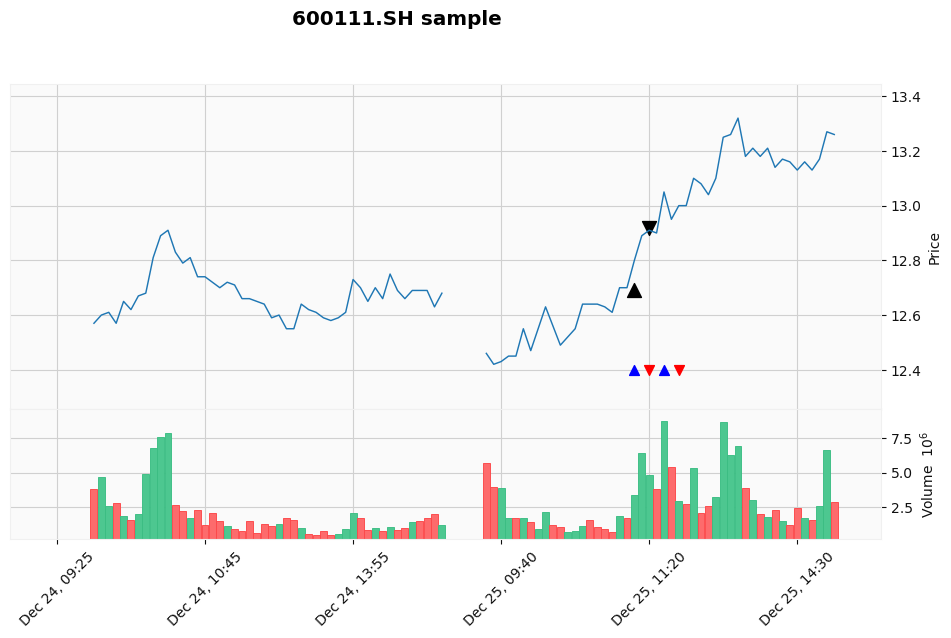

In [9]:
candle_plot(bars, f'{symbol} sample', buy_marks, sell_marks, mark_size=100, show_marks=True, del_nan=True, day_gap=True, bar_type='line')

### Save to JPG file
- folders in the path will be created if necessary

In [6]:
candle_plot(bars, f'{symbol} sample', buy_marks, sell_marks, mark_size=100, show_marks=True, del_nan=True, day_gap=True, save_to='./chart/demo.png')
print('Job done. Check the file at ./chart')

Job done. Check the file at ./chart
